## Predict Podcast Listening Time
* Loading data,
* Use visualization techniques to Exploratory Data Analysis (EDA),
* Analyze patterns related to podcast duration, genre, user behavior, other factors affecting listening time,
* Evaluating the model,
* Making predictions,

In [112]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import xgboost as xgb
from xgboost.callback import EarlyStopping

# Import the data from the CSV file
df_train = pd.read_csv("train.csv")
df_test  = pd.read_csv("test.csv")
df_sub = pd.read_csv("sample_submission.csv")
df_train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [113]:
df_train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348854,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151079,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,104.000000,119.970000


In [114]:
df_test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2,Neutral


In [115]:
df_sub.head()

,id,Listening_Time_minutes
0,750000,45.437
1,750001,45.437
2,750002,45.437
3,750003,45.437
4,750004,45.437


In [116]:
# Delete 'id' column becuase it's unused
df_train.drop(columns=['id'], inplace=True)
df_test.drop(columns=['id'], inplace=True)

In [117]:
# Check the shape (rows, columns) to confirm the size of data after cleaning
df_train.shape,df_test.shape

((750000, 11), (250000, 10))

In [118]:
# Count the number of missing (null) values in each column
df_train.isnull().sum()

Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [119]:
df_test.isnull().sum()

Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

In [120]:
df_train.shape,df_test.shape,df_sub.shape

((750000, 11), (250000, 10), (250000, 2))

In [121]:
df_train.corr(numeric_only=True)

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
Episode_Length_minutes,1.000000,0.023596,-0.009704,-0.054956,0.916749
Host_Popularity_percentage,0.023596,1.000000,0.022431,-0.017896,0.050870
Guest_Popularity_percentage,-0.009704,0.022431,1.000000,0.007933,-0.016014
Number_of_Ads,-0.054956,-0.017896,0.007933,1.000000,-0.118343
Listening_Time_minutes,0.916749,0.050870,-0.016014,-0.118343,1.000000


In [122]:
df_train.dtypes

Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
Listening_Time_minutes         float64
dtype: object

In [123]:
# Fill missing values in numerical columns with the median from training data,
# and fill missing values in categorical columns with the mode from training data,
# ensuring consistency between train and test datasets.

common_cols = df_train.columns.intersection(df_test.columns)

numerical_cols = df_train[common_cols].select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_train[common_cols].select_dtypes(include=['object']).columns

df_train[numerical_cols] = df_train[numerical_cols].fillna(df_train[numerical_cols].median())
df_test[numerical_cols] = df_test[numerical_cols].fillna(df_train[numerical_cols].median())
df_train[categorical_cols] = df_train[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))
df_test[categorical_cols] = df_test[categorical_cols].apply(lambda x: x.fillna(df_train[x.name].mode()[0]))

In [124]:
common_cols = df_train.columns.intersection(df_test.columns)
categorical_cols = df_train[common_cols].select_dtypes(include=['object']).columns

In [125]:
# قراءة البيانات
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# تحديد الهدف y والخصائص X
y = df_train['Listening_Time_minutes']
X = df_train.drop(columns=['Listening_Time_minutes'])

# تأكد أن بيانات الاختبار تحوي نفس الأعمدة مثل X (نفس الترتيب)
X_test = df_test[X.columns]

# ترميز الأعمدة النصية (categorical encoding)
encoded_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in encoded_columns:
    X[col] = X[col].astype('category').cat.codes
    X_test[col] = X_test[col].astype('category').cat.codes

# تعريف دالة RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# إعدادات موديل XGBoost
xgb_params = {
    'n_estimators': 565,
    'max_depth': 14,
    'learning_rate': 0.04222221,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'tree_method': 'hist',  # بدل gpu_hist إذا ما عندك دعم GPU
    'n_jobs': -1,
    'early_stopping_rounds': 100
}

n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

scores = []
test_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
    )
    
    val_pred = model.predict(X_val)
    score = rmse(y_val, val_pred)
    scores.append(score)
    
    test_preds += model.predict(X_test) / n_splits
    print(f"Fold {fold + 1} RMSE: {score:.4f}")

print(f'Optimized Cross-validated RMSE score: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
print(f'Max RMSE score: {np.max(scores):.3f}')
print(f'Min RMSE score: {np.min(scores):.3f}')

# هنا تقدر تحفظ نتائج التنبؤ النهائية للملف المقدم submission
submission = pd.read_csv('sample_submission.csv')
submission['Listening_Time_minutes'] = test_preds
submission.to_csv('submission.csv', index=False)

Training fold 1/3...
[0]	validation_0-rmse:26.26871
[100]	validation_0-rmse:13.07492
[200]	validation_0-rmse:12.92615
[300]	validation_0-rmse:12.90336
[400]	validation_0-rmse:12.90023
[448]	validation_0-rmse:12.89960
Fold 1 RMSE: 12.8969
Training fold 2/3...
[0]	validation_0-rmse:26.28810
[100]	validation_0-rmse:13.09203
[200]	validation_0-rmse:12.93376
[300]	validation_0-rmse:12.90618
[400]	validation_0-rmse:12.89976
[500]	validation_0-rmse:12.89731
[564]	validation_0-rmse:12.89497
Fold 2 RMSE: 12.8947
Training fold 3/3...
[0]	validation_0-rmse:26.26185
[100]	validation_0-rmse:13.07354
[200]	validation_0-rmse:12.91815
[300]	validation_0-rmse:12.88764
[400]	validation_0-rmse:12.88155
[500]	validation_0-rmse:12.88295
[526]	validation_0-rmse:12.88214
Fold 3 RMSE: 12.8800
Optimized Cross-validated RMSE score: 12.891 +/- 0.008
Max RMSE score: 12.897
Min RMSE score: 12.880


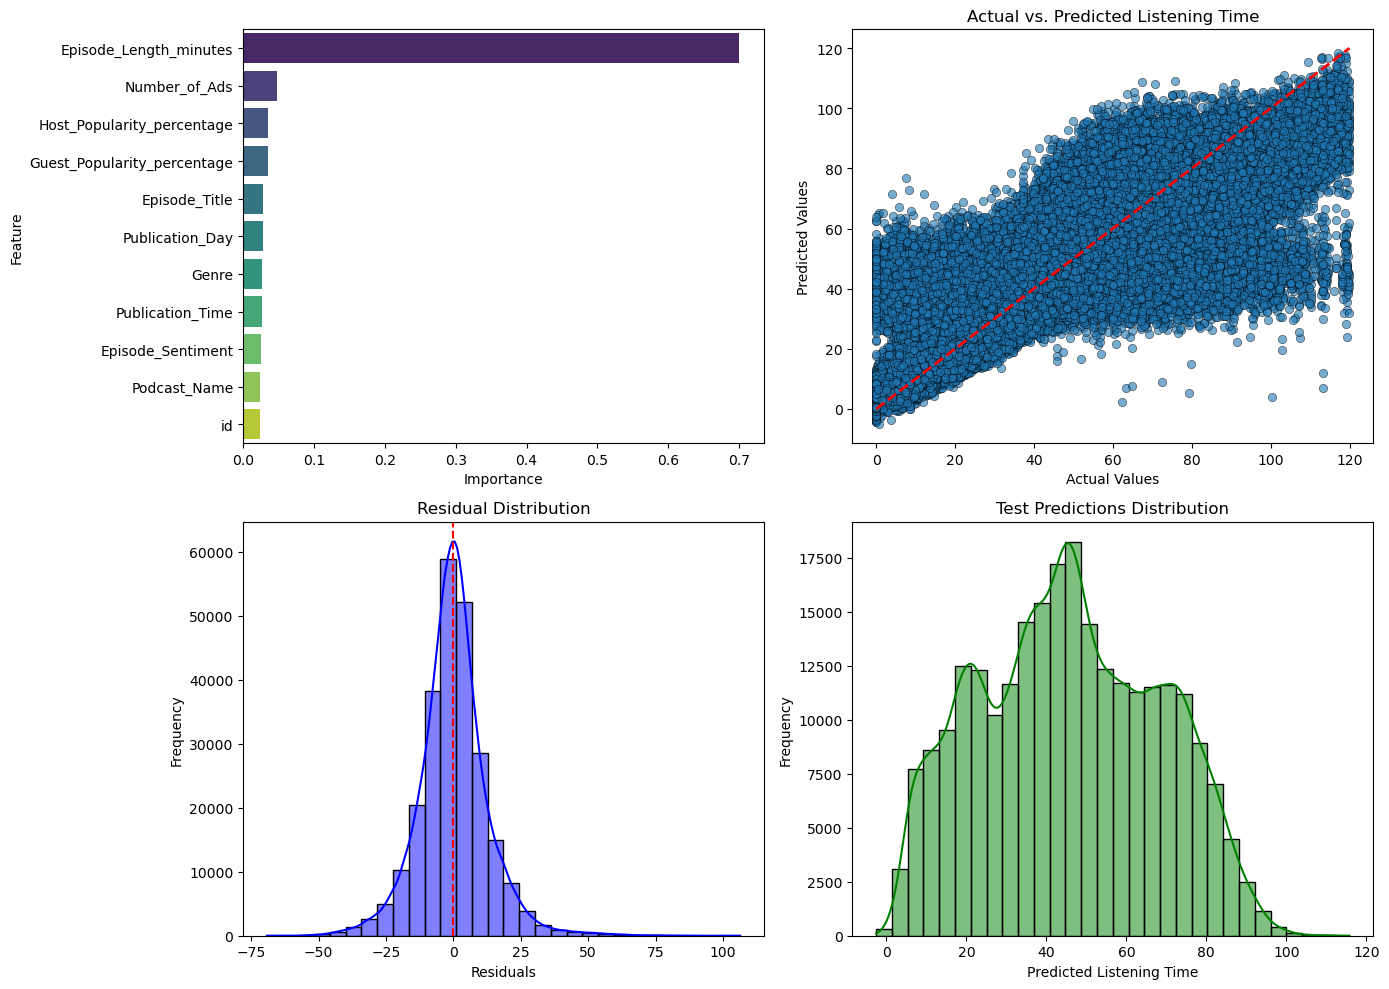

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

feature_importance = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette=sns.color_palette("viridis", n_colors=len(importance_df)),
    hue="Feature",
    dodge=False,
    legend=False,
    ax=axes[0, 0]
)


sns.scatterplot(x=y_val, y=val_pred, alpha=0.6, edgecolors="k", ax=axes[0, 1])
axes[0, 1].plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--r', linewidth=2) 
axes[0, 1].set_title("Actual vs. Predicted Listening Time")
axes[0, 1].set_xlabel("Actual Values")
axes[0, 1].set_ylabel("Predicted Values")

residuals = y_val - val_pred
sns.histplot(residuals, bins=30, kde=True, color='blue', ax=axes[1, 0])
axes[1, 0].axvline(0, color='red', linestyle='--')
axes[1, 0].set_title("Residual Distribution")
axes[1, 0].set_xlabel("Residuals")
axes[1, 0].set_ylabel("Frequency")

sns.histplot(test_preds, bins=30, kde=True, color='green', ax=axes[1, 1])
axes[1, 1].set_title("Test Predictions Distribution")
axes[1, 1].set_xlabel("Predicted Listening Time")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [127]:
df_sub.head()

,id,Listening_Time_minutes
0,750000,45.437
1,750001,45.437
2,750002,45.437
3,750003,45.437
4,750004,45.437


In [128]:
df_sub['Listening_Time_minutes'] = test_preds

In [129]:
df_sub.to_csv('submission.csv', index=False)

In [130]:
df_sub.head()

,id,Listening_Time_minutes
0,750000,54.801350
1,750001,22.797104
2,750002,51.750317
3,750003,70.549229
4,750004,47.949847


In [131]:
df_sub['Listening_Time_minutes'].hist()

<Axes: >

In [147]:
importance_df.to_csv('importance_df.csv', index=False)

np.save('y_val.npy', y_val)
np.save('val_pred.npy', val_pred)
np.save('test_preds.npy', test_preds)